In [2]:
import numpy as np
import pandas as pd
import os
print(os.listdir("all"))

['sample_submission.csv', 'test.json', 'train.json']


In [3]:
train = pd.read_json('all/train.json')
test = pd.read_json('all/test.json')
sample_submission = pd.read_csv('all/sample_submission.csv')

In [4]:
print(test.columns)
print(train.columns)
print(sample_submission.head(4))

Index(['audio_embedding', 'end_time_seconds_youtube_clip',
       'start_time_seconds_youtube_clip', 'vid_id'],
      dtype='object')
Index(['audio_embedding', 'end_time_seconds_youtube_clip', 'is_turkey',
       'start_time_seconds_youtube_clip', 'vid_id'],
      dtype='object')
        vid_id  is_turkey
0  pyKh38FXD3E          0
1  THhP1idrWXA          0
2  jsw3T6GY2Nw          0
3  nFkXTMHcjMU          0


In [5]:
print(train.shape)
print(test.shape)

(1195, 5)
(1196, 4)


In [6]:
print(train[train['is_turkey']==1].index)

Int64Index([   1,    2,    3,    8,   12,   13,   18,   21,   23,   26,
            ...
            1163, 1165, 1168, 1169, 1172, 1173, 1174, 1184, 1185, 1192],
           dtype='int64', length=491)


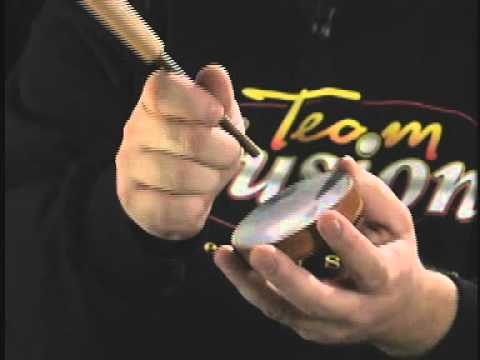

In [7]:
from IPython.display import YouTubeVideo
YouTubeVideo(train['vid_id'][1],start=train['start_time_seconds_youtube_clip'][1],end=train['end_time_seconds_youtube_clip'][1])

In [8]:
print(train['audio_embedding'].head())

#see the possible list lengths of the first dimension
print("train's audio_embedding can have this many frames: "+ str(train['audio_embedding'].apply(lambda x: len(x)).unique())) 
print("test's audio_embedding can have this many frames: "+ str(test['audio_embedding'].apply(lambda x: len(x)).unique())) 

#see the possible list lengths of the first element
print("each frame can have this many features: "+str(train['audio_embedding'].apply(lambda x: len(x[0])).unique()))

0    [[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...
1    [[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...
2    [[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...
3    [[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...
4    [[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...
Name: audio_embedding, dtype: object
train's audio_embedding can have this many frames: [10  9  2  3  8  5  6  7  4]
test's audio_embedding can have this many frames: [10  9  4  2  8  7  3  6  1]
each frame can have this many features: [128]


In [35]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import regularizers

#split the training data to have a validation set
train_train, train_val = train_test_split(train)
xtrain = [k for k in train_train['audio_embedding']]
ytrain = train_train['is_turkey'].values

xval = [k for k in train_val['audio_embedding']]
yval = train_val['is_turkey'].values

# Pad the audio features so that all are "10 seconds" long
x_train = pad_sequences(xtrain, maxlen=10)
x_val = pad_sequences(xval, maxlen=10)

y_train = np.asarray(ytrain)
y_val = np.asarray(yval)

#Define a basic LSTM model
model = Sequential()
model.add(BatchNormalization(input_shape=(10, 128)))
model.add(Dropout(.5))
model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dense(16, activation="relu", kernel_initializer="uniform", kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

#maybe there is something better to use, but let's use binary_crossentropy
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#fit on a portion of the training data, and validate on the rest
model.fit(x_train, y_train,
          batch_size=300,
          epochs=4,validation_data=(x_val, y_val))

# Get accuracy of model on validation data. It's not AUC but it's something at least!
score, acc = model.evaluate(x_val, y_val, batch_size=300)
print('Test accuracy:', acc)

Train on 896 samples, validate on 299 samples
Epoch 1/4
896/896 [==============================] - 16s 18ms/step - loss: 0.6266 - acc: 0.7299 - val_loss: 1.1114 - val_acc: 0.7157
Epoch 2/4
896/896 [==============================] - 2s 2ms/step - loss: 0.4221 - acc: 0.8951 - val_loss: 0.4928 - val_acc: 0.9064
Epoch 3/4
896/896 [==============================] - 2s 2ms/step - loss: 0.2408 - acc: 0.9263 - val_loss: 0.8265 - val_acc: 0.9231
Epoch 4/4
299/299 [==============================] - 0s 662us/step
Test accuracy: 0.9264214038848877


In [20]:
x_train[0]

array([[161,   0, 177, ..., 111, 187, 255],
       [177,  16, 209, ..., 255,  98, 255],
       [173,  22, 196, ..., 176, 118, 255],
       ...,
       [168,  15, 208, ..., 183,  95, 255],
       [178,  16, 241, ..., 234, 231, 255],
       [171,  20, 208, ..., 213,   5, 255]])

In [21]:
test_data = [k for k in test['audio_embedding']]
submission = model.predict_classes(pad_sequences(test_data))
submission = pd.DataFrame({'vid_id':test['vid_id'].values,'is_turkey':[x for y in submission for x in y]})

In [22]:
print(submission.head())

        vid_id  is_turkey
0  pyKh38FXD3E          0
1  THhP1idrWXA          0
2  jsw3T6GY2Nw          0
3  nFkXTMHcjMU          0
4  Au8g9kAlrLQ          1


In [23]:
submission.to_csv('lstm_starter.csv', index=False)